In [1]:
import pandas as pd
import os
import random
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt 

from transformers import BertModel, BertTokenizer 
import torch

/Users/sachichitre/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#import data
mammals = pd.read_excel('./data/promptListMammal.xlsx')
reptiles = pd.read_excel('./data/promptListReptile.xlsx')
birds = pd.read_excel('./data/promptListBird.xlsx')
bugs = pd.read_excel('./data/promptListBugs.xlsx')
fish = pd.read_excel('./data/promptListFish.xlsx')
 
#print(fish)

In [3]:
# Picking 15 random prompts from each dataset
# reptiles_15 = reptiles.sample(n=15, random_state=0)
mammals_15 = mammals.sample(n=15, random_state=0)
list_of_strings = mammals_15[0].astype(str).tolist()

# Print the list of strings
print(list_of_strings)
# mam = mammals_15.to_string(index=False)
# mammals_sampled = mammals.sample(n=10, random_state=0)
# mammals_list = mammals_sampled.squeeze().toList()
# fish_15 = fish.sample(n=15, random_state=0)
# bugs_15 = bugs.sample(n=15, random_state=0)
# birds_15 = birds.sample(n=15, random_state=0)
print(mammals_15)
type(mammals_15)
# type(mammals_list)

['Is a Brown Hyena a mammal?', 'Is a Bobcat a mammal?', 'Is a Pied Tamarin a mammal?', 'Is a Akbash a mammal?', 'Is a Peruvian Inca Orchid a mammal?', 'Is a Eskipoo a mammal?', 'Is a Pugshire a mammal?', 'Is a Cheetah a mammal?', 'Is a Yoranian a mammal?', 'Is a Spanish Mastiff a mammal?', 'Is a American Eskimo Dog a mammal?', 'Is a Boxerdoodle a mammal?', 'Is a Fox Terrier a mammal?', 'Is a Zuchon a mammal?', 'Is a Dorgi a mammal?']
                                       0
150           Is a Brown Hyena a mammal?
122                Is a Bobcat a mammal?
546          Is a Pied Tamarin a mammal?
14                 Is a Akbash a mammal?
542  Is a Peruvian Inca Orchid a mammal?
279               Is a Eskipoo a mammal?
579              Is a Pugshire a mammal?
187               Is a Cheetah a mammal?
767              Is a Yoranian a mammal?
670       Is a Spanish Mastiff a mammal?
31    Is a American Eskimo Dog a mammal?
142           Is a Boxerdoodle a mammal?
301           Is a Fox Terrie

pandas.core.frame.DataFrame

In [4]:
# Load pre-trained BertModel and BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
model = BertModel.from_pretrained('bert-base-uncased' ) 

In [5]:
# Function to find the animal name between "a" or "an" and "mammal" using vector embeddings
def find_animal_name_embeddings(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get the embeddings for the prompt
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # Shape: (num_tokens, embedding_size)
#         sentence_embedding = torch.mean(last_hidden_states, dim=1) 
#         embedding_array = sentence_embedding.detach().numpy()
    
    # Define the target words
    target_start_words = ["a", "an"]
    target_end_word = "a"

    # Initialize variables to hold the indices of the target words
    start_index = None
    end_index = None

    # Iterate through the tokens and embeddings to find the indices of the target words
    for i, token in enumerate(tokens):
        
        if token in target_start_words:
            # Check if the next token is a potential animal name
            
            for j in range(i + 1, len(tokens)):
                if tokens[j] == target_end_word:
                    start_index = i + 1
                    end_index = j
                    
                    break
#             if start_index is not None and end_index is not None:
#                 break
#     print(start_index, end_index)
     # If indices are found, calculate average embedding for the animal name
    if start_index is not None and end_index is not None:
        # Extract embeddings for the animal name
        animal_name_state = last_hidden_states[0, start_index:end_index, :]
        # Calculate mean embedding across tokens
        animal_name_embedding = animal_name_state.mean(dim=0)
        # Convert to numpy array
        animal_name_embedding_np = animal_name_embedding.detach().numpy()
        
        # Convert tokens to string
        animal_name_tokens = tokens[start_index:end_index]
        animal_name = tokenizer.convert_tokens_to_string(animal_name_tokens)
        
        return animal_name, animal_name_embedding_np
    
    # Return None if the animal name is not found
    return None, None

# Testing the function
# prompt1 = "is a brown hyena a mammal?"
# animal_name1, embeddings1 = find_animal_name_embeddings(prompt1)
# print(f"Animal name in prompt: '{animal_name1}', Embeddings shape: {embeddings1.shape}")
# print(len(embeddings1))

# prompt2 = "do you know if a platypus is a mammal?"
# animal_name2, embeddings2 = find_animal_name_embeddings(prompt2)
# print(f"Animal name in prompt: '{animal_name2}', Embeddings shape: {embeddings2.shape}")

# prompt3 = "an ostrich is a bird, but is it a mammal?"
# animal_name3, embeddings3 = find_animal_name_embeddings(prompt3)
# print(f"Animal name in prompt: '{animal_name3}', Embeddings shape: {embeddings3.shape}")


Animal name in prompt: 'brown hyena', Embeddings shape: (768,)
768


In [6]:
def getEmbedding(text):
    tokens = tokenizer(text, return_tensors='pt') 
    outputs = model(**tokens) # Transformer layers
    last_hidden_states = outputs.last_hidden_state 
    sentence_embedding = torch.mean(last_hidden_states, dim=1) 
    embedding_array = sentence_embedding.detach().numpy() 
    return embedding_array 

In [7]:
# finds the animal name token vector embeddings within prompt for mammal
vecEmbedsMammals = []
vecName = []
for vecM in list_of_strings:
    animal_name, embeddings = find_animal_name_embeddings(vecM)
    vecEmbedsMammals.append(embeddings)
    vecName.append(animal_name)

vecEmbedsMammals2 = []
for vecM2 in list_of_strings:
    prompt_embedding = getEmbedding(vecM2)
    vecEmbedsMammals2.append(prompt_embedding)
type(vecEmbedsMammals)

# Print the list of vector embeddings of animal names
#print(vecEmbedsMammals)
# print(vecEmbedsMammals2)
# print(len(vecEmbedsMammals2))

15


In [8]:
### Creating Cosine Distance Matrix ###
# print(vecEmbedsMammals2)
vecEmbedsMammals2_reshaped = [np.array(embedding).reshape(-1) for embedding in vecEmbedsMammals2]
cosineMatrix = np.zeros((len(vecEmbedsMammals), len(vecEmbedsMammals2_reshaped)))
# Calculate cosine distances and angles between each pair of embeddings
for i in range(len(vecEmbedsMammals)):
    for j in range(len(vecEmbedsMammals2_reshaped)):
        cosineMatrix[i][j] = 1 - distance.cosine(vecEmbedsMammals[i], vecEmbedsMammals2_reshaped[j])
angleMatrix = np.arccos(cosineMatrix) * 180 / np.pi

In [9]:
angleMatrix

array([[31.64521406, 49.77579321, 48.51364003, 52.0997684 , 55.06189868,
        56.66526798, 56.66657191, 43.72509017, 54.88553654, 50.98951915,
        50.88858492, 53.62295009, 50.79305056, 53.5563869 , 54.55029698],
       [46.1465823 , 39.22278091, 46.69450313, 49.88111317, 53.52630738,
        53.33934768, 48.95630543, 45.68228991, 53.16113755, 47.13967486,
        50.55899233, 49.02640757, 47.38050819, 51.43449463, 52.11468529],
       [50.76987743, 52.79346538, 30.71208038, 51.70431103, 54.97196562,
        53.61909857, 51.68507956, 49.68602702, 52.92187985, 52.60219092,
        50.82874083, 52.04921373, 51.90706978, 53.92855666, 51.24791248],
       [53.93739512, 54.83462013, 51.12133165, 37.27071002, 56.29994173,
        51.60102613, 54.58653484, 52.22032827, 51.52742313, 54.4574316 ,
        51.1844135 , 55.79609891, 54.80299432, 53.37534271, 53.02343675],
       [58.39512308, 59.19602306, 56.44732952, 56.85451536, 40.65036155,
        57.29305416, 58.70569268, 59.28748354, 

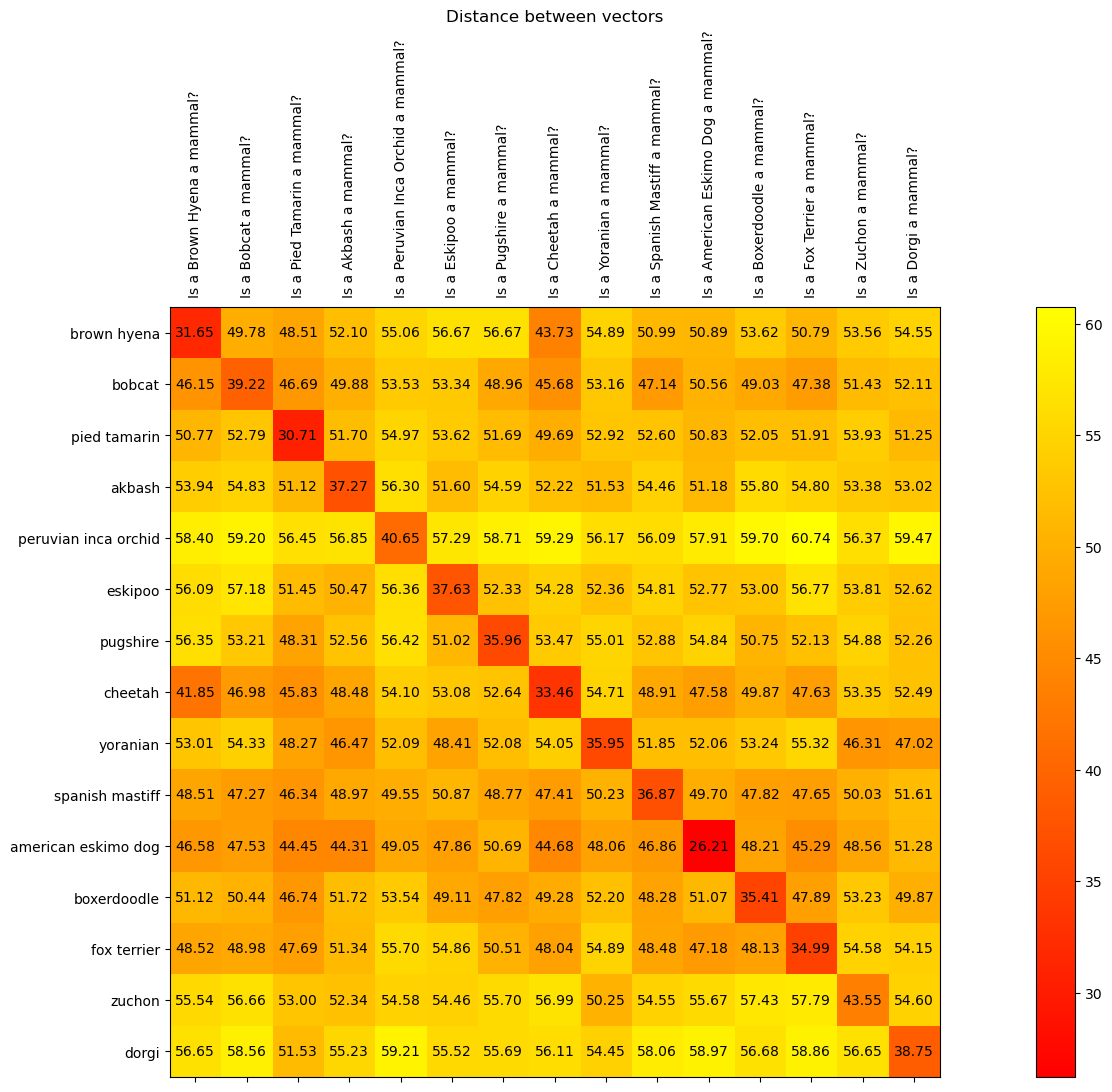

In [10]:
# Plotting Results in Heatmap
plt.figure(figsize=(25, 10)) 
plt.imshow(angleMatrix, cmap='autumn')

# Add cell values as text annotations
for i in range(len(vecEmbedsMammals)):
    for j in range(len(vecEmbedsMammals2_reshaped)):
        plt.annotate(f'{angleMatrix[i][j]:.2f}', xy=(j, i), ha='center', va='center')

plt.title("Distance between vectors") 
plt.xticks(np.arange(len(list_of_strings)), list_of_strings, rotation=90) #prompts
plt.yticks(np.arange(len(vecName)), vecName) # animal words
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()